In [1]:
# improve speed of SVC in sklearn
# might not be supported by some hardware
# if causes errors - ignore
from sklearnex import patch_sklearn
patch_sklearn("SVC")


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../..')

import numpy as np
import pandas as pd

from database.dataset import *
from machine_learning.cascade_classifier import CascadeClassifier

from metrics.metrics_utils import get_froc_df_of_many_imgs_features
from metrics.metrics import froc_curve
from general_utils.plots import plot_froc
from general_utils.utils import non_max_supression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

In [3]:
# from machine_learning.ml_detector import DetectorML
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria

In [4]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['validation'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)


In [5]:
clf = CascadeClassifier('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl')
# clf2 = CascadeClassifier2('/home/vzalevskyi/projects/data/cascade/cascade_models.pkl')

Loading model...
Selected sensitivity threshold to keep 0.98
Confidence threshold to keep given sensitivity is 0.00380
Filtering out all candidates with confidence <=0.00380 is estimated to reduce FP by 49.97 %


In [6]:
save_path = Path.cwd().parent.parent.parent/'data/test_features/val/circular'

circ_all_features = pd.read_feather(str(save_path) + 'features.f')
circ_all_tps = pd.read_feather(str(save_path) + 'tps.f')
circ_all_fps = pd.read_feather(str(save_path) + 'fps.f')
circ_all_fns = pd.read_feather(str(save_path) + 'fns.f')
circ_all_ignored_candidates = pd.read_feather(str(save_path) + 'ignored_candidates.f')

In [7]:
# CHECKS IF FILTERING EASY NEGATIVES USING FIRST MODELS PROBAS IF BETTER

# all_features = []
# all_tps = []
# all_fps = []
# all_fns = []
# all_ignored_candidates = []
# save_path = Path.cwd().parent.parent/'data/test_features/val/circular'
# for idx in tqdm(range(len(db))):
#     # extracting data
#     db_sample = db[idx]
#     image = db_sample['img']
#     image_id = db.df.iloc[idx].img_id
#     image_mask = db_sample['lesion_mask']

#     cand_features_probas = circ_all_features[circ_all_features.img_id == image_id]
#     cand_features_probas['confidence2'] = clf2.predict(cand_features_probas)
#     cand_features_probas['img_id'] = image_id
    
#     tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
#         np.stack(cand_features_probas.candidate_coordinates.values).astype(int), image_mask, None, 14, True)
#     tp['img_id'] = image_id
#     fp['img_id'] = image_id
#     fn['img_id'] = image_id
#     ignored_candidates['img_id'] = image_id
    
#     all_features.append(cand_features_probas)
#     all_tps.append(tp)
#     all_fps.append(fp)
#     all_fns.append(fn)
#     all_ignored_candidates.append(ignored_candidates)
    

# all_features = pd.DataFrame(all_features)
# all_tps = pd.DataFrame(all_tps)
# all_fps = pd.DataFrame(all_fps)
# all_fns = pd.DataFrame(all_fns)
# all_ignored_candidates = pd.DataFrame(all_ignored_candidates)


  0%|          | 0/62 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_312562/3809364679.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_features_probas['confidence2'] = clf2.predict(cand_features_probas)
/tmp/ipykernel_312562/3809364679.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [8]:
cand_features_probas

,index,haar_0,haar_1,haar_2,haar_3,haar_4,haar_5,haar_6,haar_7,haar_8,...,patch_glcm_dissimilarity_HL1_1,patch_glcm_dissimilarity_HL1_2,patch_glcm_dissimilarity_HH1_0,patch_glcm_dissimilarity_HH1_1,patch_glcm_dissimilarity_HH1_2,candidate_coordinates,patch_coordinates,confidence,img_id,confidence2
9172,0,-0.250605,-0.341168,0.200830,0.344971,0.238507,-0.398894,0.307293,0.261666,0.227446,...,5104.833333,6782.800000,64.857143,58.111111,68.914286,"[161, 3481, 2]","[[3474, 3488], [154, 168]]",0.054130,20587638,0.054130
9173,1,-0.050467,-0.053232,0.029036,0.022468,0.025233,-0.048047,0.026270,0.013826,0.035258,...,5520.416667,4252.200000,70.742857,57.527778,48.085714,"[202, 3479, 1]","[[3472, 3486], [195, 209]]",0.001934,20587638,0.001934
9174,2,-0.036295,-0.077774,0.081231,0.193225,0.163498,-0.090563,0.110957,0.123747,0.222952,...,5793.527778,6045.885714,67.742857,59.027778,58.400000,"[196, 3478, 2]","[[3471, 3485], [189, 203]]",0.034844,20587638,0.034844
9175,3,-0.125475,-0.195645,0.127204,0.289665,0.224680,-0.257172,0.192188,0.232285,0.276184,...,3129.611111,6605.342857,75.314286,47.611111,69.571429,"[82, 3478, 2]","[[3471, 3485], [75, 89]]",0.284312,20587638,0.284312
9176,4,-0.058417,-0.090218,0.112340,0.248185,0.175251,-0.149672,0.185275,0.174905,0.213619,...,2986.944444,5844.542857,76.028571,42.611111,60.028571,"[129, 3477, 1]","[[3470, 3484], [122, 136]]",0.264526,20587638,0.264526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10151,979,-0.079848,-0.100588,-0.083305,-0.100933,-0.093674,-0.127549,-0.090563,-0.129969,-0.111994,...,4921.138889,5890.428571,52.828571,55.361111,61.171429,"[2, 303, 0]","[[296, 310], [0, 14]]",0.009576,20587638,0.009576
10152,980,-0.194608,-0.274456,0.153820,0.218113,0.204286,-0.319392,0.167646,0.209125,0.225372,...,5528.888889,9967.714286,79.742857,61.500000,82.628571,"[363, 295, 0]","[[288, 302], [356, 370]]",0.132694,20587638,0.132694
10153,981,-0.013135,-0.036640,-0.070169,-0.126512,-0.118216,-0.029381,-0.078465,-0.146906,-0.147252,...,6335.000000,10321.800000,55.457143,62.500000,81.285714,"[2, 275, 0]","[[268, 282], [0, 14]]",0.006102,20587638,0.006102
10154,982,-0.100933,-0.145869,0.077083,0.128586,0.078465,-0.177670,0.127204,0.087798,0.096440,...,10467.194444,12628.485714,69.085714,83.527778,94.200000,"[144, 271, 0]","[[264, 278], [137, 151]]",0.008645,20587638,0.008645


In [25]:
all_features = []
all_tps = []
all_fps = []
all_fns = []
all_ignored_candidates = []
save_path = Path.cwd().parent.parent/'data/test_features/val/circular'
for idx in tqdm(range(len(db))):
    # extracting data
    db_sample = db[idx]
    image = db_sample['img']
    image_id = db.df.iloc[idx].img_id
    image_mask = db_sample['lesion_mask']

    cand_features_probas = circ_all_features[circ_all_features.img_id == image_id]
    cand_features_probas['confidence2'] = clf.predict(cand_features_probas)
    cand_features_probas['img_id'] = image_id
    
    
    cand_features_probas['plot_bboxes'] = [[x[1][0], x[1][1], x[0][0], x[0][1], cand_features_probas.confidence.values[xidx]]
                                 for xidx, x in enumerate(cand_features_probas.patch_coordinates.values)]
    cand_features_probas = cand_features_probas.iloc[non_max_supression(np.stack(cand_features_probas['plot_bboxes']), 0.1, True),:]
    
    
    tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
        np.stack(cand_features_probas.candidate_coordinates.values).astype(int), image_mask, None, 14, True)
    tp['img_id'] = image_id
    fp['img_id'] = image_id
    fn['img_id'] = image_id
    ignored_candidates['img_id'] = image_id
    
    all_features.append(cand_features_probas)
    all_tps.append(tp)
    all_fps.append(fp)
    all_fns.append(fn)
    all_ignored_candidates.append(ignored_candidates)
    

all_features = pd.DataFrame(all_features)
all_tps = pd.DataFrame(all_tps)
all_fps = pd.DataFrame(all_fps)
all_fns = pd.DataFrame(all_fns)
all_ignored_candidates = pd.DataFrame(all_ignored_candidates)


  0%|          | 0/62 [00:00<?, ?it/s]INFO:root:sklearn.svm.SVC._predict_proba: running accelerated version on CPU
INFO:root:sklearn.svm.SVC.decision_function: running accelerated version on CPU
/tmp/ipykernel_326982/1891819419.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_features_probas['confidence2'] = clf.predict(cand_features_probas)
/tmp/ipykernel_326982/1891819419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cand_features_probas['img_id'] = image_id
/tmp/ipykernel_326982/189181941

In [26]:
all_features = pd.concat(all_features[0].values).reset_index()
all_tps = pd.concat(all_tps[0].values).reset_index()
all_fps = pd.concat(all_fps[0].values).reset_index()
all_fns = pd.concat(all_fns[0].values).reset_index()
all_ignored_candidates = pd.concat(all_ignored_candidates[0].values).reset_index()


In [7]:
# circ_all_ignored_candidates['candidate_coordinates'] = (circ_all_ignored_candidates.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1)).astype(str)
circ_all_tps['candidate_coordinates_str'] = (circ_all_tps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
circ_all_tps['candidate_coordinates'] = (circ_all_tps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

circ_all_fps['candidate_coordinates_str'] = (circ_all_fps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
circ_all_fps['candidate_coordinates'] = (circ_all_fps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

circ_all_features['candidate_coordinates_str'] = circ_all_features.apply(lambda r:  f"[{r['candidate_coordinates'][0]}, {r['candidate_coordinates'][1]}, {r['candidate_coordinates'][2]}]", axis=1)

circ_all_tps_conf = circ_all_tps.merge(circ_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])
circ_all_fps_conf = circ_all_fps.merge(circ_all_features[['img_id', 'candidate_coordinates_str', 'confidence']], on=['img_id', 'candidate_coordinates_str'])

circle_cands = pd.concat([circ_all_tps_conf, circ_all_fps_conf])

circle_cands['label'] = circle_cands['label']=='TP'

In [27]:
# all_ignored_candidates['candidate_coordinates'] = (all_ignored_candidates.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1)).astype(str)
all_tps['candidate_coordinates_str'] = (all_tps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
all_tps['candidate_coordinates'] = (all_tps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

all_fps['candidate_coordinates_str'] = (all_fps.apply(lambda r: f"[{r['x']}, {r['y']}, {r['radius']}]", axis=1))
all_fps['candidate_coordinates'] = (all_fps.apply(lambda r: [r['x'], r['y'], r['radius']], axis=1))

all_features['candidate_coordinates_str'] = all_features.apply(lambda r:  f"[{r['candidate_coordinates'][0]}, {r['candidate_coordinates'][1]}, {r['candidate_coordinates'][2]}]", axis=1)

all_tps_conf = all_tps.merge(all_features[['img_id', 'candidate_coordinates_str', 'confidence2']], on=['img_id', 'candidate_coordinates_str'])
all_fps_conf = all_fps.merge(all_features[['img_id', 'candidate_coordinates_str', 'confidence2']], on=['img_id', 'candidate_coordinates_str'])

all_cands = pd.concat([all_tps_conf, all_fps_conf])

all_cands['label'] = all_cands['label']=='TP'

In [28]:
# (all_cands.confidence2 != circle_cands.confidence).sum()

In [35]:
normal_imgs_ids = db.get_normal_imgs_ids()


froc_df_1st = get_froc_df_of_many_imgs_features(
    circle_cands[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    circ_all_fns,
    circle_cands.confidence.values,
    normal_imgs_ids
)

sens1, avgs_fp_per_image1, froc_thrs = froc_curve(
    froc_df_1st, non_max_supression=True, cut_on_50fpi=True)

In [29]:
froc_df_2st = get_froc_df_of_many_imgs_features(
    all_cands[['candidate_coordinates', 'label',
                   'img_id', 'matching_gt', 'repeted_idxs']],
    all_fns,
    all_cands.confidence2.values,
    normal_imgs_ids
)

sens2, avgs_fp_per_image2, _ = froc_curve(
    froc_df_2st, non_max_supression=True, cut_on_50fpi=True)

In [30]:
len(all_cands) - len(circle_cands)

-37314

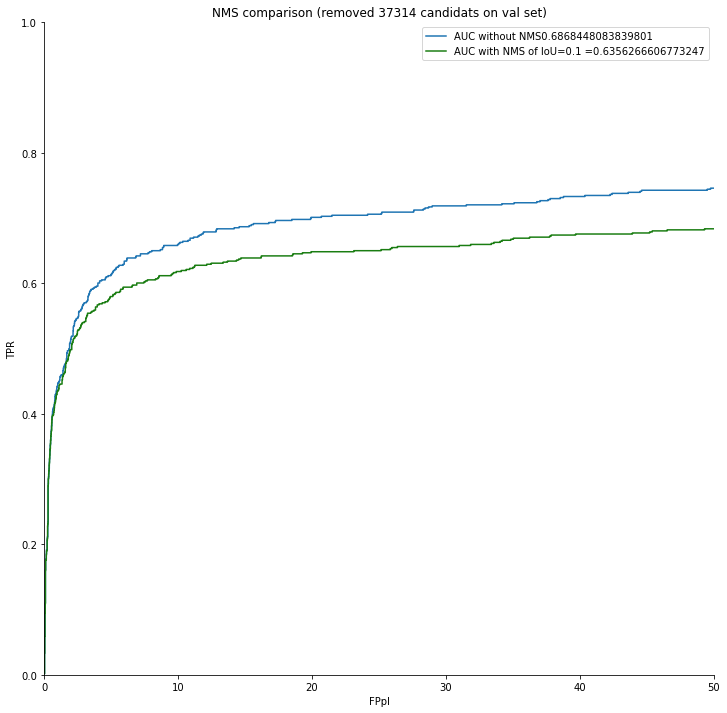

In [32]:
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(1, 1, 1)

plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs, color=(0.12, 0.46, 0.7, 1.0))


plot_froc(avgs_fp_per_image2, sens2, title=f'NMS comparison (removed {-len(all_cands) + len(circle_cands)} candidats on val set)',
          cut_on_50fpi=True, ax=axs, color=(0.1, 0.49, 0.07, 1.0))

avgs_fp_per_image1 = np.asarray(avgs_fp_per_image1)
avgs_fp_per_image2 = np.asarray(avgs_fp_per_image2)
plt.legend([f'AUC without NMS{auc(avgs_fp_per_image1/avgs_fp_per_image1.max(), sens1)}',
            f'AUC with NMS of IoU=0.1 ={auc(avgs_fp_per_image2/avgs_fp_per_image2.max(), sens2)}',
            ])


In [92]:
thr01 = np.argmax(froc_thrs<=0.10436767122881145)
thr05 = np.argmax(froc_thrs<=0.99)

Text(0.4096774193548387, 0.8, '0.15')

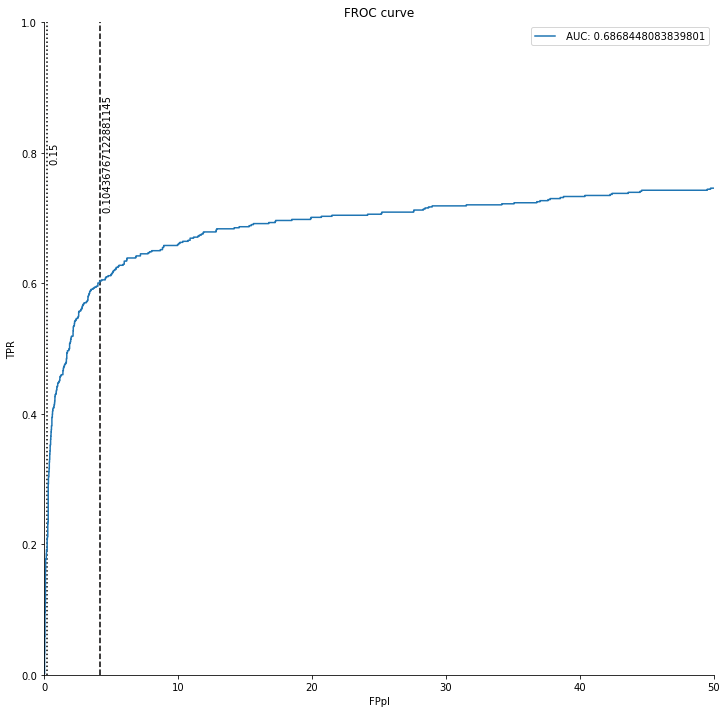

In [93]:
fig = plt.figure(figsize=(12, 12))
axs = fig.add_subplot(1, 1, 1)

plot_froc(avgs_fp_per_image1, sens1, cut_on_50fpi=True,
          ax=axs, color=(0.12, 0.46, 0.7, 1.0))

plt.vlines(avgs_fp_per_image1[thr01], 0, 1, colors=[(255, 0, 0, 1)], linestyles='dashed', label='0.15')
plt.vlines(avgs_fp_per_image1[thr05], 0, 1, colors=[(255, 255, 0, 1)], linestyles='dotted', label='0.5')
plt.text(avgs_fp_per_image1[thr01] + 0.2, 0.8, '0.10436767122881145', rotation=90, verticalalignment='center')
plt.text(avgs_fp_per_image1[thr05] + 0.2, 0.8, '0.15', rotation=90, verticalalignment='center')

Find  Youden's index on FROC curve

In [77]:
idx = np.argmax(np.array(sens1) - np.array(avgs_fp_per_image1)/max(avgs_fp_per_image1))
froc_thrs[idx]

0.10436767122881145

Find  Youden's index on ROC curve

In [34]:
def sensivity_specifity_cutoff(y_true: np.ndarray, y_score: np.ndarray):
    '''Finds data-driven cut-off for classification
    Cut-off is determied using Youden's index defined as sensitivity + specificity - 1.
    Args:
      y_true (np.ndarray): True binary labels.
      y_score (np.ndarray): Target scores.
    '''
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    idx = np.argmax(tpr - fpr)
    return thresholds[idx]


In [36]:
sensivity_specifity_cutoff(circle_cands.label, circle_cands.confidence)

0.023734223841560386

In [35]:
circle_cands

,index,x,y,radius,label,repeted_idxs,matching_gt,img_id,candidate_coordinates_str,candidate_coordinates,confidence
0,0,984,2654,1,True,0.0,2.0,20587294,"[984, 2654, 1]","[984, 2654, 1]",0.999962
1,1,1514,1552,0,True,1.0,1.0,20587294,"[1514, 1552, 0]","[1514, 1552, 0]",0.796326
2,0,1517,1525,2,True,0.0,1.0,20587346,"[1517, 1525, 2]","[1517, 1525, 2]",0.999946
3,0,92,3446,6,True,0.0,1.0,20587612,"[92, 3446, 6]","[92, 3446, 6]",0.161359
4,1,78,3423,4,True,1.0,2.0,20587612,"[78, 3423, 4]","[78, 3423, 4]",0.914904
...,...,...,...,...,...,...,...,...,...,...,...
116931,1875,299,98,0,False,1878.0,NaN,51048972,"[299, 98, 0]","[299, 98, 0]",0.034101
116932,1876,0,94,0,False,1879.0,NaN,51048972,"[0, 94, 0]","[0, 94, 0]",0.000201
116933,1877,0,40,3,False,1880.0,NaN,51048972,"[0, 40, 3]","[0, 40, 3]",0.023621
116934,1878,60,30,0,False,1881.0,NaN,51048972,"[60, 30, 0]","[60, 30, 0]",0.032310


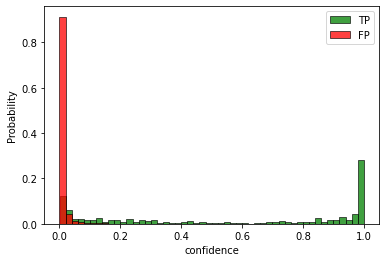

In [21]:
sns.histplot(circle_cands[circle_cands.label].confidence, color='g', bins=50, stat='probability')
sns.histplot(circle_cands[~circle_cands.label].confidence, color='r', bins=50, stat='probability')
plt.legend(['TP', 'FP'])

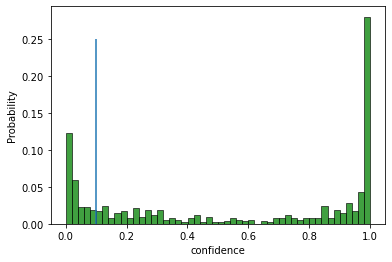

In [34]:
sns.histplot(circle_cands[circle_cands.label].confidence, color='g', bins=50, stat='probability')
plt.vlines(0.1, 0, 0.25)

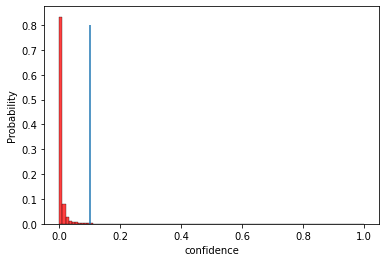

In [33]:
sns.histplot(circle_cands[~circle_cands.label].confidence, color='r', bins=100, stat='probability')
plt.vlines(0.1, 0, 0.8)